---


Датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>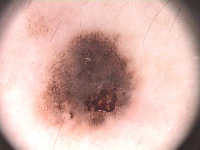</td><td>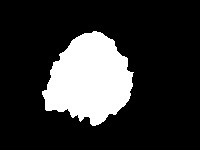</td></tr></table>


Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данной работе не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=8acbf6ed-c994-40f6-8b2c-02228dd756a5
To: /content/PH2Dataset.rar
100% 162M/162M [00:01<00:00, 81.2MB/s]


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Датасет имеет следующую структуру:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений используем [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, нарисуем несколько изображений

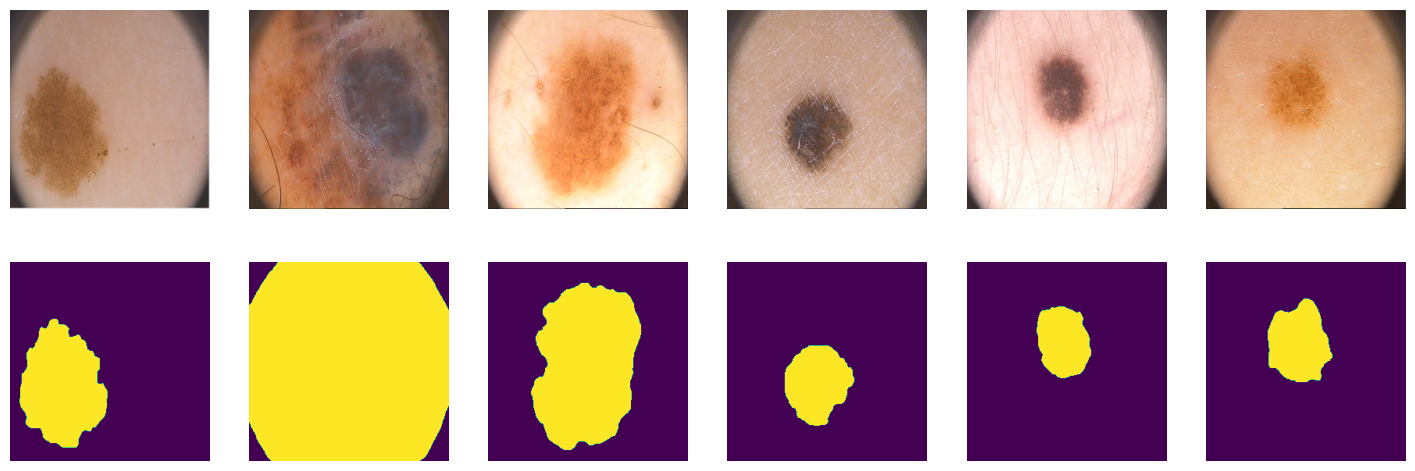

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
X_train = X[tr]
Y_train = Y[tr]

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25

train_dataloader = DataLoader(list(zip(np.rollaxis(X_train, 3, 1), Y_train[np.newaxis].reshape([-1, 1, 256, 256]))),
                     batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

Буду использовать следующую метрику:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.



<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 18.1 MB/s eta 0:00:00


## BCE Loss

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта функция потерь страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Существует следующее упрощение данной формулы [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Продемонстрирую, как получить последнюю формулу из стандартной формулы бинарной кросс-энтропии

1: Подстановка сигмоидной функции в исходную формулу

Подставим выражение для $\sigma(\hat{y}_i)$ в исходную формулу:

\begin{equation}
L_{BCE}(y, \hat{y}) = -\sum_i \left[ y_i \log \left( \frac{1}{1 + \exp(-\hat{y}_i)} \right) + (1 - y_i) \log \left( 1 - \frac{1}{1 + \exp(-\hat{y}_i)} \right) \right]
\end{equation}

2: Упрощение логарифмов

Для первого слагаемого:
\begin{align}
\log \left( \frac{1}{1 + \exp(-\hat{y}_i)} \right) &= -\log(1 + \exp(-\hat{y}_i))
\end{align}

Для второго слагаемого:
\begin{align}
1 - \sigma(\hat{y}_i) &= 1 - \frac{1}{1 + \exp(-\hat{y}_i)} = \frac{\exp(-\hat{y}_i)}{1 + \exp(-\hat{y}_i)} \\
\log \left( 1 - \sigma(\hat{y}_i) \right) &= \log \left( \frac{\exp(-\hat{y}_i)}{1 + \exp(-\hat{y}_i)} \right) = -\hat{y}_i - \log(1 + \exp(-\hat{y}_i))
\end{align}

3: Объединение

Подставляем упрощенные выражения обратно в формулу:

\begin{equation}
L_{BCE}(y, \hat{y}) = -\sum_i \left[ y_i (-\log(1 + \exp(-\hat{y}_i))) + (1 - y_i)(-\hat{y}_i - \log(1 + \exp(-\hat{y}_i))) \right]
\end{equation}

Раскрываем скобки:

\begin{equation}
L_{BCE}(y, \hat{y}) = \sum_i \left[ y_i \log(1 + \exp(-\hat{y}_i)) + (1 - y_i)(\hat{y}_i + \log(1 + \exp(-\hat{y}_i))) \right]
\end{equation}

4: Приведение к численно стабильной форме

Разделяем слагаемые:

\begin{equation}
L_{BCE}(y, \hat{y}) = \sum_i \left[ \hat{y}_i - y_i \hat{y}_i + \log(1 + \exp(-\hat{y}_i)) \right]
\end{equation}

Итоговая численно стабильная формула для BCE Loss:

\begin{equation}
L_{BCE} = \hat{y} - y\hat{y} + \log(1 + \exp(-\hat{y}))
\end{equation}


Реализую следующие две функции потерь:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравню с реализациями PyTorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [ ]:
import torch.nn.functional as F
import torch.nn as nn
import torch

In [ ]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [ ]:
def bce_loss(y_pred, y_real):
  y_pred = torch.sigmoid(y_pred)
  L = -torch.sum(y_real * torch.log(y_pred) + (1-y_real) * torch.log(1-y_pred))
  return L

def bce_true(y_pred, y_real):
  L = torch.sum(y_pred - y_real * y_pred + torch.log(1+torch.exp(-y_pred)))
  return L

In [ ]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

In [ ]:
print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss with logits = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')

BCE loss from scratch bce_loss = 4.97430944442749
BCE loss with logits = 4.97430944442749
BCE loss from torch bce_torch = 4.97430944442749
BCE loss from torch with logits bce_torch = 4.974309921264648


In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Посчитаем лоссы на простом примере

In [ ]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 13.402558326721191
BCE loss честно посчитанный = 13.402558326721191
BCE loss from torch bce_torch = 13.402558326721191
BCE loss from torch with logits bce_torch = 13.402559280395508


In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

А теперь посчитаем на реальных логитах и сегментационной маске:

In [ ]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 4.83MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 4.98MB/s]
Download completed


In [ ]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

<ipython-input-23-cd9dbfff2c1b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
<ipython-input-

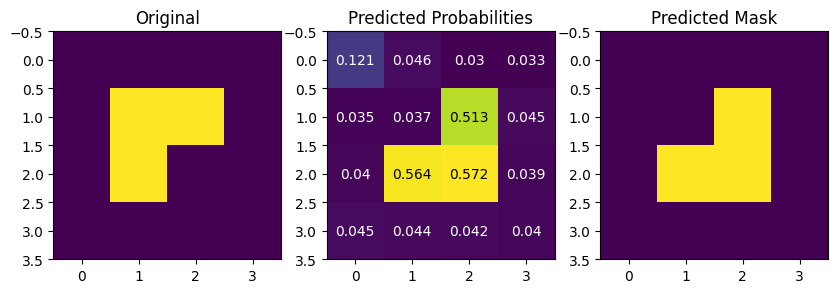

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [ ]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

-----------------------------------------------------------------------------------------

# Архитектура SegNet
Реализуем SegNet архитектуру.
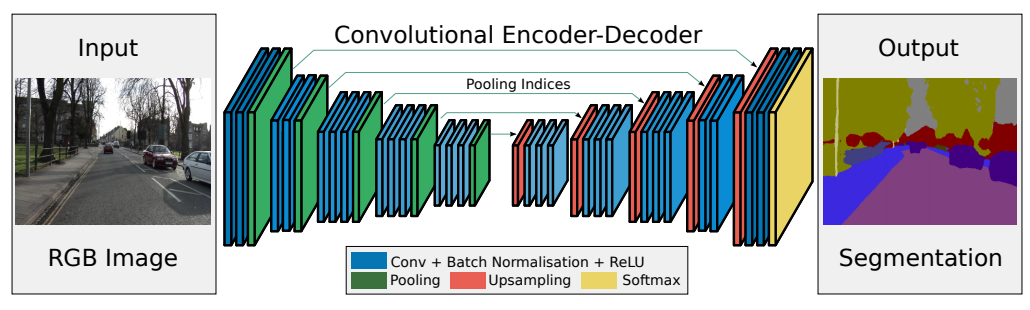

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Вспомогательные классы ConvReLU, Encoder и Decoder для того, чтобы использовать их в классе SegNet

In [ ]:
class ConvReLU(nn.Module): # реализует свёрточный слой с батч-нормализацией и функцией активации ReLU
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ConvReLU, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [ ]:
class EncoderBlock(nn.Module):
    # реализует отдельный блок Encoder
    def __init__(self, in_channels, out_channels, depth=2, kernel_size=3, padding=1):
        # параметр depth -- число слоёв ConvReLU в данном Encoder блоке
        super(EncoderBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            if i == 0:
              self.layers.append(ConvReLU(in_channels, out_channels, kernel_size, padding))
            else:
              self.layers.append(ConvReLU(out_channels, out_channels, kernel_size, padding))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x, ind = self.pool(x)
        return x, ind

In [ ]:
class DecoderBlock(nn.Module):
    # реализует отдельный блок Decoder
    def __init__(self, in_channels, out_channels, depth=2, kernel_size=3, padding=1, classification=False):
        # параметр depth -- число слоёв ConvReLU в данном Decoder блоке
        # параметр classification указывает, является ли последний слой блока слоем классификации.
        # Если True, последний слой будет обычным сверточным слоем, иначе — слоем ConvReLU.
        super(DecoderBlock, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.layers = nn.ModuleList()
        for i in range(depth):
            if i == depth - 1 and classification:
                self.layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)) # обычный сверточный слой
            elif i == depth - 1:
                self.layers.append(ConvReLU(in_channels, out_channels, kernel_size=kernel_size, padding=padding)) # слой ConvReLU
            else:
                self.layers.append(ConvReLU(in_channels, in_channels, kernel_size=kernel_size, padding=padding))

    def forward(self, x, ind):
        x = self.unpool(x, ind)
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(SegNet, self).__init__()

        # VGG-16 architecture
        self.enc0 = EncoderBlock(in_channels, 64) # 256 -> 128
        self.enc1 = EncoderBlock(64, 64 * 2) # 128 -> 64
        self.enc2 = EncoderBlock(64 * 2, 64 * 4, depth=3) # 64 -> 32
        self.enc3 = EncoderBlock(64 * 4, 64 * 8, depth=3) # 32 -> 16

        # bottleneck
        self.bottleneck_enc = EncoderBlock(64 * 8, 64 * 8, depth=3)
        self.bottleneck_dec = DecoderBlock(64 * 8, 64 * 8, depth=3)

        # decoder (upsampling)
        self.dec0 = DecoderBlock(64 * 8, 64 * 4, depth=3) # 16 -> 32
        self.dec1 = DecoderBlock(64 * 4, 64 * 2, depth=3) # 32 -> 64
        self.dec2 = DecoderBlock(64 * 2, 64) # 64 -> 128
        self.dec3 = DecoderBlock(64, out_channels, classification=True) # 128 -> 256

    def forward(self, x):
        e0, idx0 = self.enc0(x)
        e1, idx1 = self.enc1(e0)
        e2, idx2 = self.enc2(e1)
        e3, idx3 = self.enc3(e2)

        bn1, idxb = self.bottleneck_enc(e3)
        bn2 = self.bottleneck_dec(bn1, idxb)

        d0 = self.dec0(bn2, idx3)
        d1 = self.dec1(d0, idx2)
        d2 = self.dec2(d1, idx1)
        output = self.dec3(d2, idx0)

        return output # no activation

## Тренировка SegNet

In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import JaccardIndex
import os
from time import time
from IPython.display import clear_output
from torchmetrics import JaccardIndex

In [ ]:
def train_model(model, optimizer, criterion, num_epochs, train_loader, val_loader, device, ckpt_path):
    # Создаем директорию для чекпоинтов, если она не существует
    os.makedirs(ckpt_path, exist_ok=True)
    metrics = {'epoch': [], 'train_loss': [], 'val_loss': [], 'iou_score': []}
    X_val, Y_val = next(iter(val_loader))
    X_val, Y_val = X_val.to(device), Y_val.to(device).float()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.75)
    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    best_val_loss = float('inf')
    best_val_iou = 0  # Инициализация переменной для лучшего IoU
    total_training_time = 0
    for epoch in range(num_epochs):
        start_time = time()  # Начало отсчета времени
        print(f'* Epoch {epoch + 1}/{num_epochs}')

        total_train_loss = 0
        num_batches = 0
        model.train()  # Set model to training mode
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device).float()  # Move data to GPU
            optimizer.zero_grad()  # Reset gradients
            Y_pred = model(X_batch)  # Forward pass
            loss = criterion(Y_pred, Y_batch)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            scheduler.step()  # Update learning rate

            total_train_loss += loss.item()  # Accumulate average loss
            num_batches += 1
        epoch_time = time() - start_time # Время, затраченное на эпоху
        total_training_time += epoch_time  # Обновление общего времени
        avg_train_loss = total_train_loss / num_batches

        # Валидация
        with torch.no_grad():
          total_val_loss = 0
          total_iou = 0
          num_batches = 0

          for X_batch_val, Y_batch_val in val_loader:
            X_batch_val, Y_batch_val = X_batch_val.to(device), Y_batch_val.to(device).float()  # Перемещаем данные на GPU

            Y_val_pred = model(X_batch_val)  # Получаем предсказания
            val_loss = criterion(Y_val_pred, Y_batch_val)  # Вычисляем валидационные потери
            total_val_loss += val_loss.item()  # Накопление потерь

            # Вычисляем IoU
            iou_metric = iou_score((Y_val_pred).float(), Y_batch_val.int())  # Вычисляем IoU
            total_iou += iou_metric.item()  # Накопление IoU
            num_batches += 1

          # Средние значения потерь и IoU
          avg_val_loss = total_val_loss / num_batches
          avg_iou = total_iou / num_batches

        # Сохраняем метрики
        metrics['epoch'].append(epoch+1)
        metrics['train_loss'].append(avg_train_loss)
        metrics['val_loss'].append(avg_val_loss)
        metrics['iou_score'].append(avg_iou)

        # Сохранение лучшего чекпоинта
        if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          best_val_iou = avg_iou
          torch.save(model.state_dict(), os.path.join(ckpt_path, f'best_model_epoch_{epoch + 1}.pt'))
          print(f'Saved best model at epoch {epoch + 1} with validation loss: {best_val_loss:.4f} and IoU: {best_val_iou:.4f}')

        # show intermediate results
        Y_predicted = model(X_val).detach().cpu() # detach and put into cpu

        # Visualization
        clear_output(wait=True)
        fig, axes = plt.subplots(4, 5, figsize=(15, 10))
        for k in range(5):
          axes[0, k].imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')  # Перемещаем на CPU
          axes[0, k].set_title('Input Image')
          axes[0, k].axis('off')

          axes[1, k].imshow(Y_val[k, 0].cpu(), cmap='gray')  # Перемещаем на CPU
          axes[1, k].set_title('Ground Truth')
          axes[1, k].axis('off')

          axes[2, k].imshow(Y_predicted[k, 0].cpu(), cmap='gray')  # Перемещаем на CPU
          axes[2, k].set_title('Model Output')
          axes[2, k].axis('off')

          axes[3, k].imshow((torch.sigmoid(Y_predicted[k, 0]) > 0.5).int().cpu(), cmap='gray')  # Перемещаем на CPU
          axes[3, k].set_title('Thresholded Output')
          axes[3, k].axis('off')

        plt.suptitle(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}, IoU score: {avg_iou:.6f}')

        plt.show()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Loss graph
    axes[0].plot(metrics['epoch'], metrics['train_loss'], label='Train Loss', color='blue', linestyle='-')
    axes[0].plot(metrics['epoch'], metrics['val_loss'], label='Validation Loss', color='orange', linestyle='--')
    axes[0].set_title('Loss Over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlim(1, num_epochs)
    axes[0].set_xticks(np.arange(1, num_epochs+1, 1))
    axes[0].grid(True)
    axes[0].legend()

    # IoU graph
    axes[1].plot(metrics['epoch'], metrics['iou_score'], label='Validation IoU Score', color='green', marker='o')
    axes[1].set_title('Validation Score Over Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Score')
    axes[1].set_xlim(1, num_epochs)
    axes[1].set_xticks(np.arange(1, num_epochs+1, 1))
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    return (metrics, total_training_time)

In [ ]:
model = SegNet().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
ckpt_path = '/content/checkpoints_segnet_bce'
num_epochs = 10

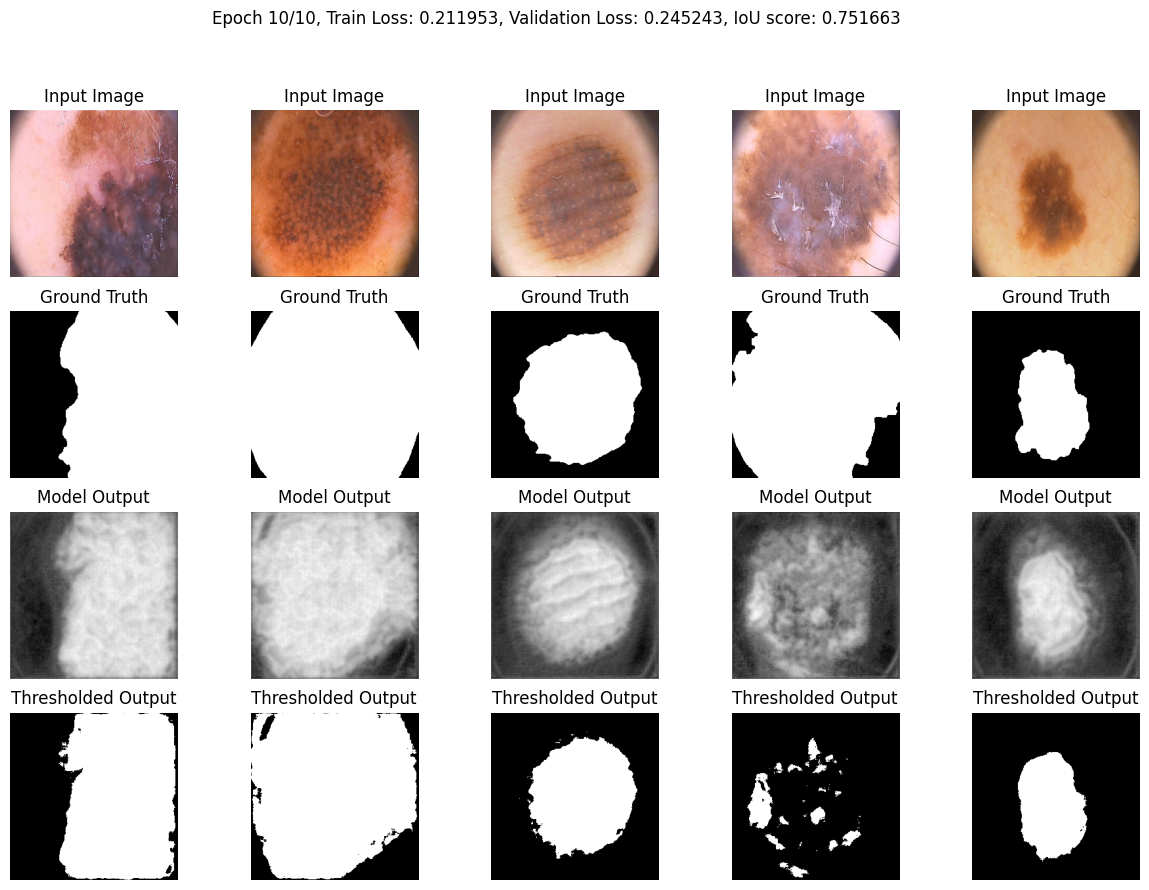

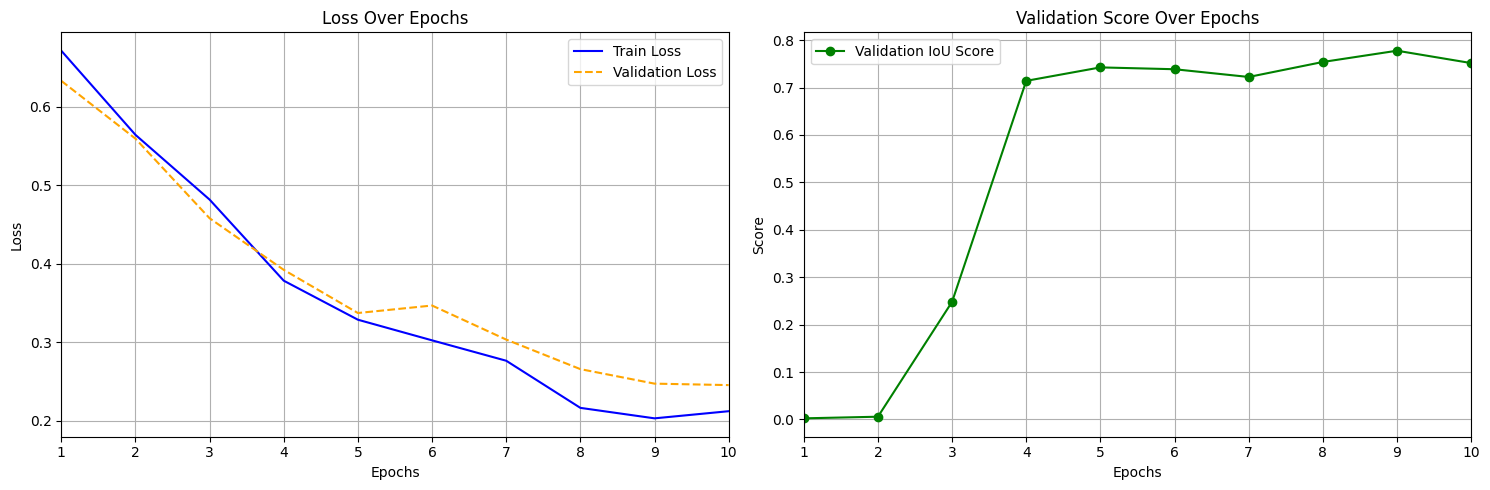

In [ ]:
metrics_segnet_bce_train_val, time_segnet_bce = train_model(model, optimizer, criterion, num_epochs, train_dataloader, val_dataloader, device, ckpt_path)

## Инференс

Возьмём вариант модели на 9 - й эпохе, так как у этого варианта наименьший loss и наибольший iou_score и протестируем работу модели на тестовой выборке

In [ ]:
ckpt_name = 'best_model_epoch_9.pt'

In [ ]:
def test(model, test_dataloader, device, ckpt_path, ckpt_name):

    model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))
    model.to(device)
    model.eval()
    metrics = {'iou': 0, 'loss': 0}
    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    avg_iou = 0
    avg_loss = 0
    with torch.no_grad():
      for X_batch, Y_batch in test_dataloader:
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch.to(device))
          loss = criterion(Y_pred, Y_batch)
          avg_iou += iou_score(Y_pred, Y_batch)
          avg_loss += loss
      avg_iou = avg_iou / len(test_dataloader)
      avg_loss = avg_loss / len(test_dataloader)
      metrics['iou'] = avg_iou
      metrics['loss'] = avg_loss

    return metrics

In [ ]:
metrics_segnet_bce = test(model, test_dataloader, device, ckpt_path, ckpt_name)

<ipython-input-36-a81f976e9b3e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


In [ ]:
loss_segnet_bce = metrics_segnet_bce['loss']
iou_segnet_bce = metrics_segnet_bce['iou']

In [ ]:
print(f'BCE Loss модели Segnet: {loss_segnet_bce}, iou_score: {iou_segnet_bce}, время обучения: {time_segnet_bce}')

BCE Loss модели Segnet: 0.26182329654693604, iou_score: 0.7511382699012756, время обучения: 42.1908757686615


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

Замечения:

1. Чтобы учесть численную нестабильность формулы, когда $\frac{0}{0}$, я добавлю очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика считается похожим образом как IoU:

    2.1. На вход приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле


3. Метрика не дифференцируема. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

In [ ]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    eps = 1e-8
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()  # Применяем порог для бинаризации

    TP = (preds * labels).sum()  # Истинные положительные
    FP = (preds * (1 - labels)).sum()  # Ложные положительные
    FN = ((1 - preds) * labels).sum()  # Ложные отрицательные

    # Вычисляем Dice
    dice = (2 * TP + eps) / (2 * TP + FP + FN + eps)

    return dice

Проверим на корректность функцию dice_score:

In [ ]:
from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

tensor(0.6667, device='cuda:0')

In [ ]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Пропишем лосс и воспользуемся библиотекой segmentation-models-pytorch, чтобы убедиться в корректности нашей функции.

In [ ]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):
    eps = 1e-8
    probs = torch.sigmoid(logits)

    TP = (probs * labels).sum()  # Истинные положительные
    FP = (probs * (1 - labels)).sum()  # Ложные положительные
    FN = ((1 - probs) * labels).sum()  # Ложные отрицательные

    # Вычисляем Dice
    dice = (2 * TP + eps) / (2 * TP + FP + FN + eps)

    # Возвращаем потери Dice
    loss = 1 - dice
    return loss

Проверка на корректность

In [ ]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=733c4bc33e8a3af4a4ac0b31a85f7dd7c799ee171ce99da7cc16feac2c378c20
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=e32ee81a3b0fb5378916b1263ee64f8d6e231aab4ed7b59a30db075e6a96b6ea
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [ ]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [ ]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** (переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [ ]:
def focal_loss(y_real, y_pred, eps=1e-8, gamma=2):
   y_pred = torch.sigmoid(y_pred)  # Применяем сигмоиду

   # Вычисляем p_t
   p_t = (y_pred * y_real) + (1 - y_pred) * (1 - y_real)

   # Вычисляем Focal Loss
   loss = - ((1 - p_t) ** gamma) * (y_real * torch.log(y_pred + eps) + (1 - y_real) * torch.log(1 - y_pred + eps))

   return loss.sum()


Проверка корректности функции:

In [ ]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [ ]:
assert torch.allclose(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2.0, reduction='sum'),
                       focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0))


In [ ]:
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2.0, reduction='sum')

tensor(3.6161, device='cuda:0')

In [ ]:
focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

tensor(3.6161, device='cuda:0')

## Обучение SegNet на DiceLoss и FocalLoss

**SegNet с DiceLoss**

In [ ]:
model = SegNet().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = dice_loss
ckpt_path = '/content/checkpoints_segnet_dice_loss'
num_epochs = 10

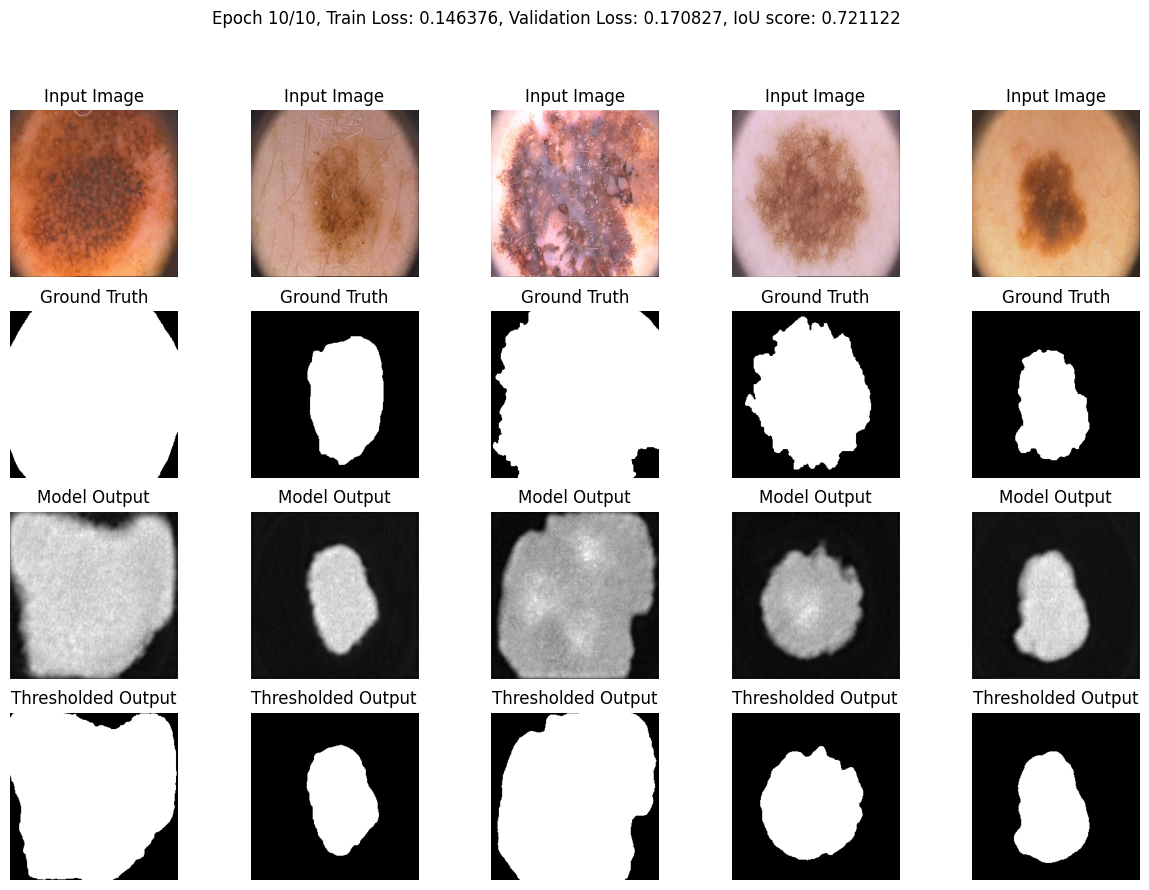

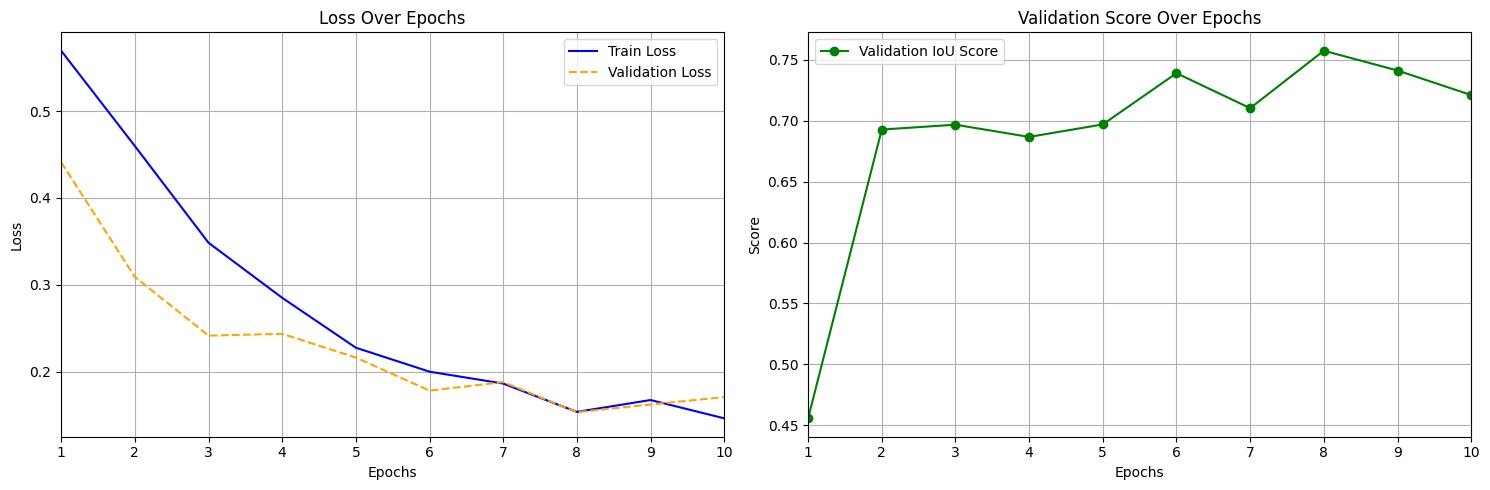

In [ ]:
metrics_segnet_dice_train_val, time_segnet_dice = train_model(model, optimizer, criterion, num_epochs, train_dataloader, val_dataloader, device, ckpt_path)

In [ ]:
ckpt_name = 'best_model_epoch_8.pt'

In [ ]:
metrics_segnet_dice = test(model, test_dataloader, device, ckpt_path, ckpt_name)

<ipython-input-36-a81f976e9b3e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


In [ ]:
loss_segnet_dice = metrics_segnet_dice['loss']
iou_segnet_dice = metrics_segnet_dice['iou']

In [ ]:
print(f'Dice Loss модели Segnet: {loss_segnet_dice}, iou_score: {iou_segnet_dice}, время обучения: {time_segnet_dice}')

Dice Loss модели Segnet: 0.18104061484336853, iou_score: 0.7153823375701904, время обучения: 43.59042000770569


In [ ]:
def train_model_with_focal_loss(model, optimizer, criterion, num_epochs, train_loader, val_loader, device, ckpt_path):
    # Создаем директорию для чекпоинтов, если она не существует
    os.makedirs(ckpt_path, exist_ok=True)
    metrics = {'epoch': [], 'train_loss': [], 'val_loss': [], 'iou_score': []}
    X_val, Y_val = next(iter(val_loader))
    X_val, Y_val = X_val.to(device), Y_val.to(device).float()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.75)
    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    best_val_loss = float('inf')
    best_val_iou = 0  # Инициализация переменной для лучшего IoU
    total_training_time = 0
    for epoch in range(num_epochs):
        start_time = time()  # Начало отсчета времени
        print(f'* Epoch {epoch + 1}/{num_epochs}')

        total_train_loss = 0
        num_batches = 0
        model.train()  # Set model to training mode
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device).float()  # Move data to GPU
            optimizer.zero_grad()  # Reset gradients
            Y_pred = model(X_batch)  # Forward pass
            loss = criterion(Y_pred, Y_batch, alpha = -1, gamma = 2, reduction = 'mean')  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            scheduler.step()  # Update learning rate

            total_train_loss += loss.item()  # Accumulate average loss
            num_batches += 1
        epoch_time = time() - start_time # Время, затраченное на эпоху
        total_training_time += epoch_time  # Обновление общего времени
        avg_train_loss = total_train_loss / num_batches

        # Валидация
        with torch.no_grad():
          total_val_loss = 0
          total_iou = 0
          num_batches = 0

          for X_batch_val, Y_batch_val in val_loader:
            X_batch_val, Y_batch_val = X_batch_val.to(device), Y_batch_val.to(device).float()  # Перемещаем данные на GPU

            Y_val_pred = model(X_batch_val)  # Получаем предсказания
            val_loss = criterion(Y_val_pred, Y_batch_val,  alpha = -1, gamma = 2, reduction = 'mean')  # Вычисляем валидационные потери
            total_val_loss += val_loss.item()  # Накопление потерь

            # Вычисляем IoU
            iou_metric = iou_score((Y_val_pred).float(), Y_batch_val.int())  # Вычисляем IoU
            total_iou += iou_metric.item()  # Накопление IoU
            num_batches += 1

          # Средние значения потерь и IoU
          avg_val_loss = total_val_loss / num_batches
          avg_iou = total_iou / num_batches

        # Сохраняем метрики
        metrics['epoch'].append(epoch+1)
        metrics['train_loss'].append(avg_train_loss)
        metrics['val_loss'].append(avg_val_loss)
        metrics['iou_score'].append(avg_iou)

        # Сохранение лучшего чекпоинта
        if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          best_val_iou = avg_iou
          torch.save(model.state_dict(), os.path.join(ckpt_path, f'best_model_epoch_{epoch + 1}.pt'))
          print(f'Saved best model at epoch {epoch + 1} with validation loss: {best_val_loss:.4f} and IoU: {best_val_iou:.4f}')

        # show intermediate results
        Y_predicted = model(X_val).detach().cpu() # detach and put into cpu

        # Visualization
        clear_output(wait=True)
        fig, axes = plt.subplots(4, 5, figsize=(15, 10))
        for k in range(5):
          axes[0, k].imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')  # Перемещаем на CPU
          axes[0, k].set_title('Input Image')
          axes[0, k].axis('off')

          axes[1, k].imshow(Y_val[k, 0].cpu(), cmap='gray')  # Перемещаем на CPU
          axes[1, k].set_title('Ground Truth')
          axes[1, k].axis('off')

          axes[2, k].imshow(Y_predicted[k, 0].cpu(), cmap='gray')  # Перемещаем на CPU
          axes[2, k].set_title('Model Output')
          axes[2, k].axis('off')

          axes[3, k].imshow((torch.sigmoid(Y_predicted[k, 0]) > 0.5).int().cpu(), cmap='gray')  # Перемещаем на CPU
          axes[3, k].set_title('Thresholded Output')
          axes[3, k].axis('off')

        plt.suptitle(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}, IoU score: {avg_iou:.6f}')

        plt.show()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Loss graph
    axes[0].plot(metrics['epoch'], metrics['train_loss'], label='Train Loss', color='blue', linestyle='-')
    axes[0].plot(metrics['epoch'], metrics['val_loss'], label='Validation Loss', color='orange', linestyle='--')
    axes[0].set_title('Loss Over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlim(1, num_epochs)
    axes[0].set_xticks(np.arange(1, num_epochs+1, 1))
    axes[0].grid(True)
    axes[0].legend()

    # IoU graph
    axes[1].plot(metrics['epoch'], metrics['iou_score'], label='Validation IoU Score', color='green', marker='o')
    axes[1].set_title('Validation Score Over Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Score')
    axes[1].set_xlim(1, num_epochs)
    axes[1].set_xticks(np.arange(1, num_epochs+1, 1))
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    return (metrics, total_training_time)

In [ ]:
def test_model_with_focal_loss(model, criterion, test_dataloader, device, ckpt_path, ckpt_name):

    model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))
    model.to(device)
    model.eval()
    metrics = {'iou': 0, 'loss': 0}
    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    avg_iou = 0
    avg_loss = 0
    with torch.no_grad():
      for X_batch, Y_batch in test_dataloader:
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch.to(device))
          loss = criterion(Y_pred, Y_batch, alpha = -1, gamma = 2, reduction = 'mean')
          avg_iou += iou_score(Y_pred, Y_batch)
          avg_loss += loss
      avg_iou = avg_iou / len(test_dataloader)
      avg_loss = avg_loss / len(test_dataloader)
      metrics['iou'] = avg_iou
      metrics['loss'] = avg_loss

    return metrics

**SegNet с Focal loss**

In [ ]:
from torchvision.ops import sigmoid_focal_loss

In [ ]:
model = SegNet().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = sigmoid_focal_loss
ckpt_path = '/content/checkpoints_segnet_focal_loss'
num_epochs = 10

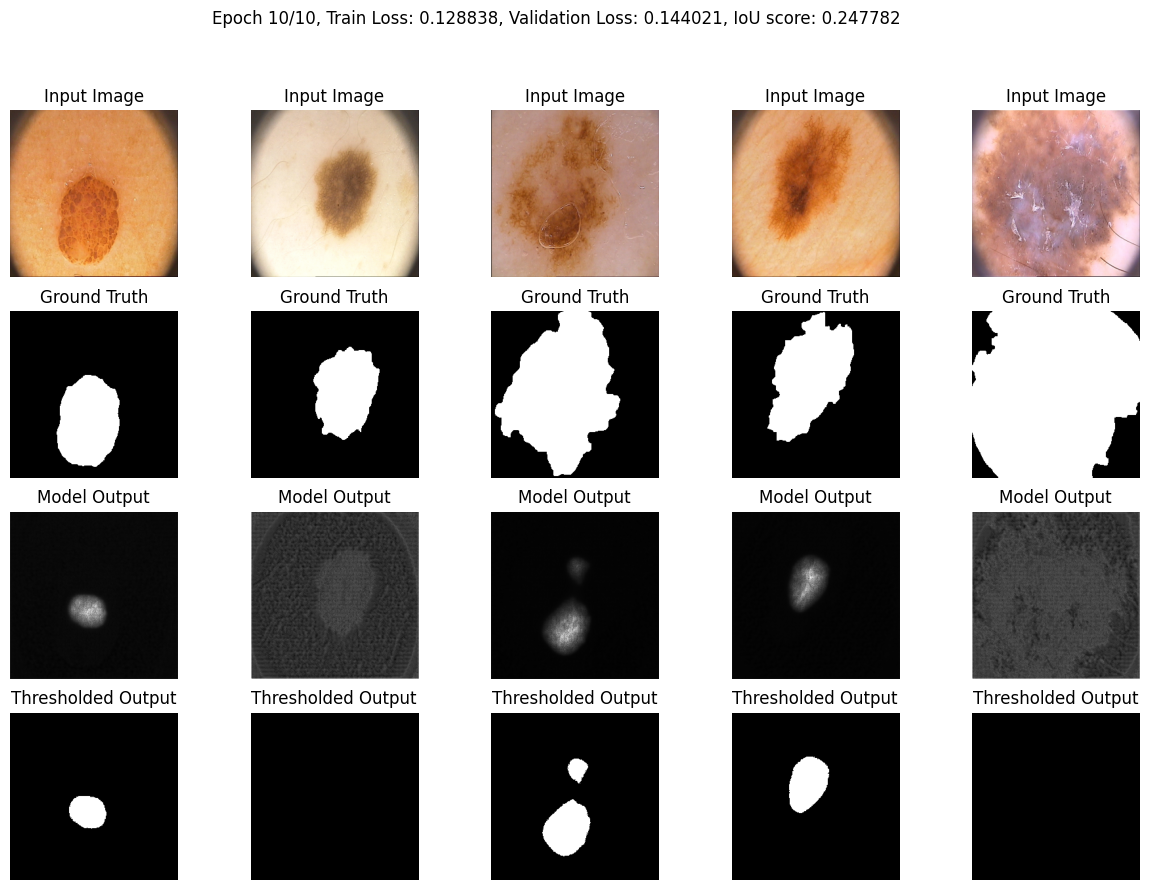

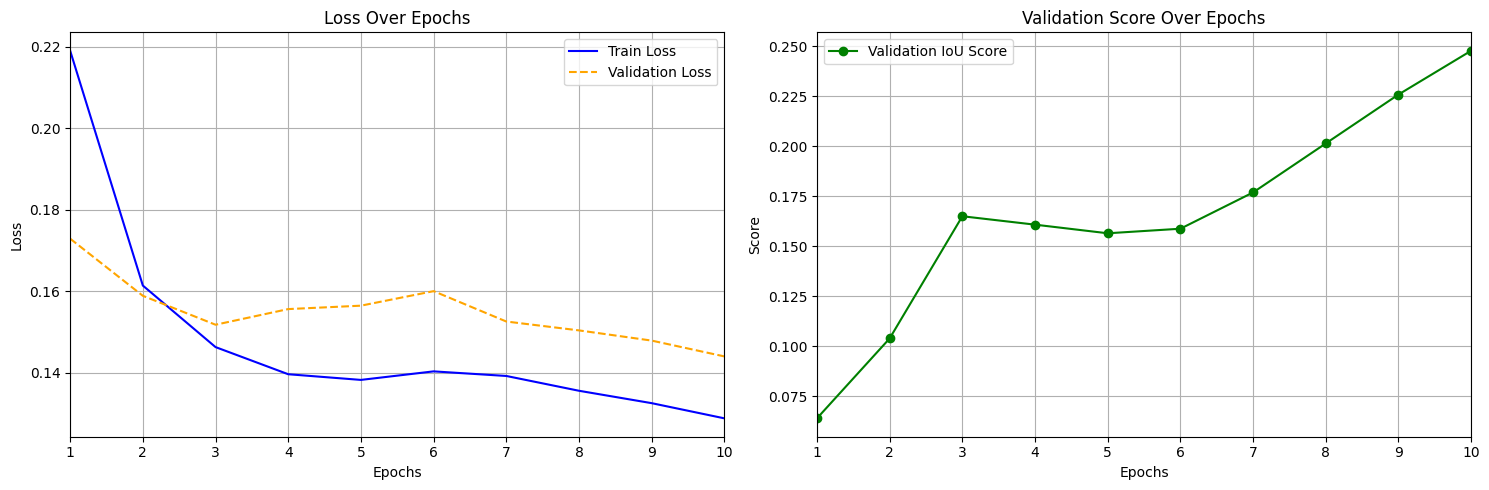

In [ ]:
metrics_segnet_focal_train_val, time_segnet_focal = train_model_with_focal_loss(model, optimizer, criterion, num_epochs, train_dataloader, val_dataloader, device, ckpt_path)

In [ ]:
ckpt_name = 'best_model_epoch_10.pt'

In [ ]:
metrics_segnet_focal = test_model_with_focal_loss(model, criterion, test_dataloader, device, ckpt_path, ckpt_name)

<ipython-input-69-5d1046dce256>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


In [ ]:
loss_segnet_focal = metrics_segnet_focal['loss']
iou_segnet_focal = metrics_segnet_focal['iou']

In [ ]:
print(f'Focal Loss модели Segnet: {loss_segnet_focal}, iou_score: {iou_segnet_focal}, время обучения: {time_segnet_focal}')

Focal Loss модели Segnet: 0.1661064177751541, iou_score: 0.04126550257205963, время обучения: 42.94926118850708


-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (здесь он именно так и будет использоваться), но он также применяется и в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

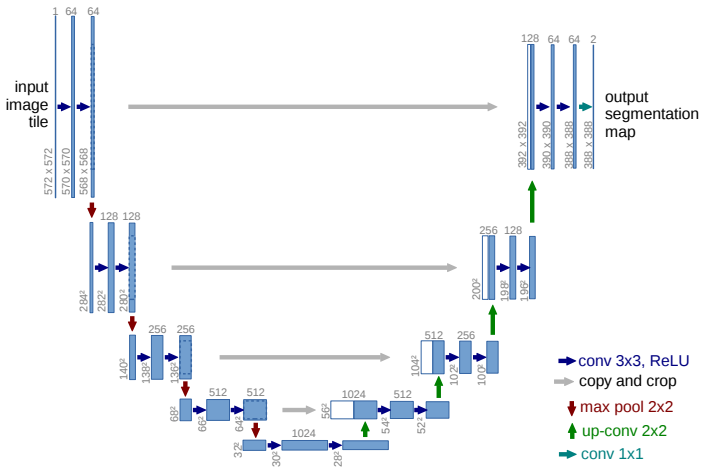

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool0 =  nn.MaxPool2d(kernel_size=2, return_indices=True) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2)# 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2)# 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )

        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)# 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )

        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)# 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1),
            )
    def forward(self, x):
        # encoder

        enc0 = self.enc_conv0(x)
        pool0, indices_e0 = self.pool0(enc0)
        enc1 = self.enc_conv1(pool0)
        pool1, indices_e1 = self.pool1(enc1)
        enc2 = self.enc_conv2(pool1)
        pool2, indices_e2 = self.pool2(enc2)
        enc3 = self.enc_conv3(pool2)
        pool3, indices_e3 = self.pool3(enc3)

        # bottleneck
        b = self.bottleneck_conv(pool3)

        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b, indices_e3), enc3), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0, indices_e2), enc2), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1, indices_e1), enc1), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2, indices_e0), enc0), dim=1))
        # no activation
        return d3

**Модель UNet с функцией потерь BCE**

In [ ]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
ckpt_path = '/content/checkpoints_Unet_BCEloss'
num_epochs = 10

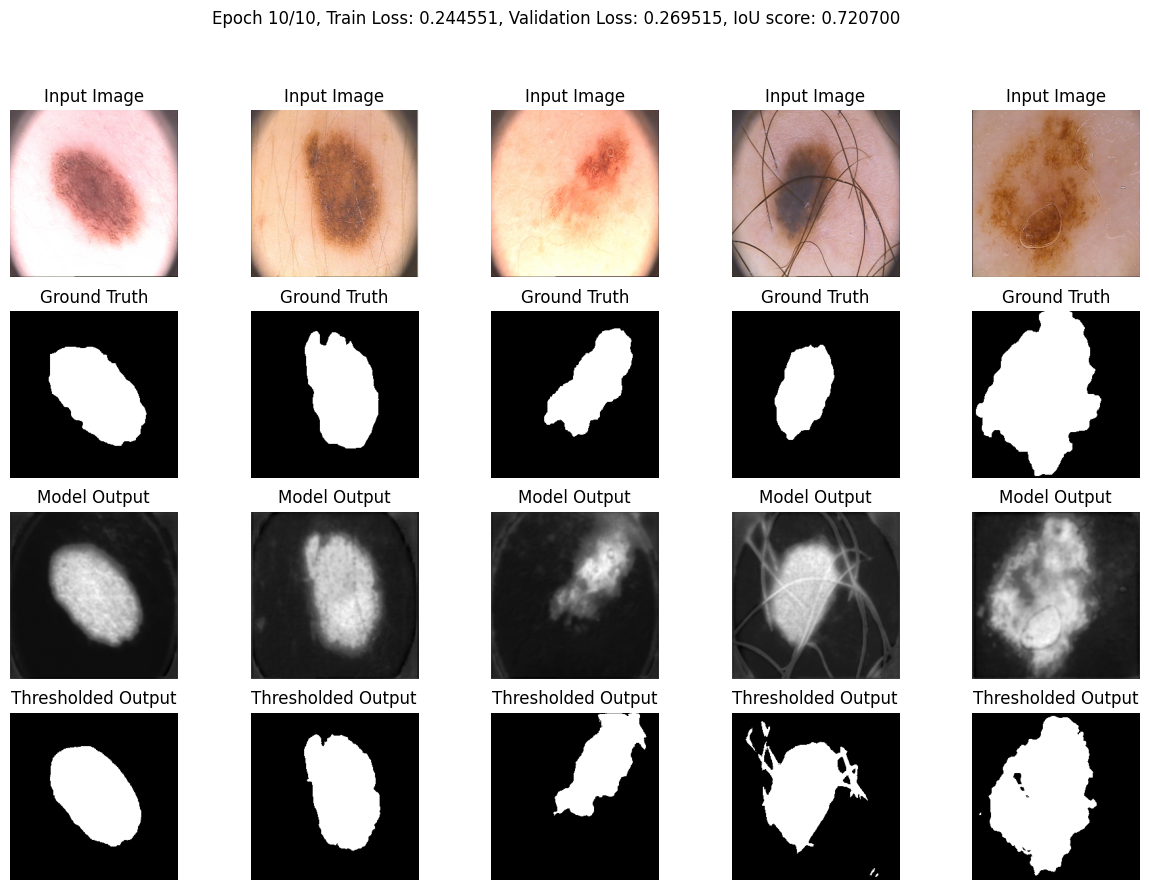

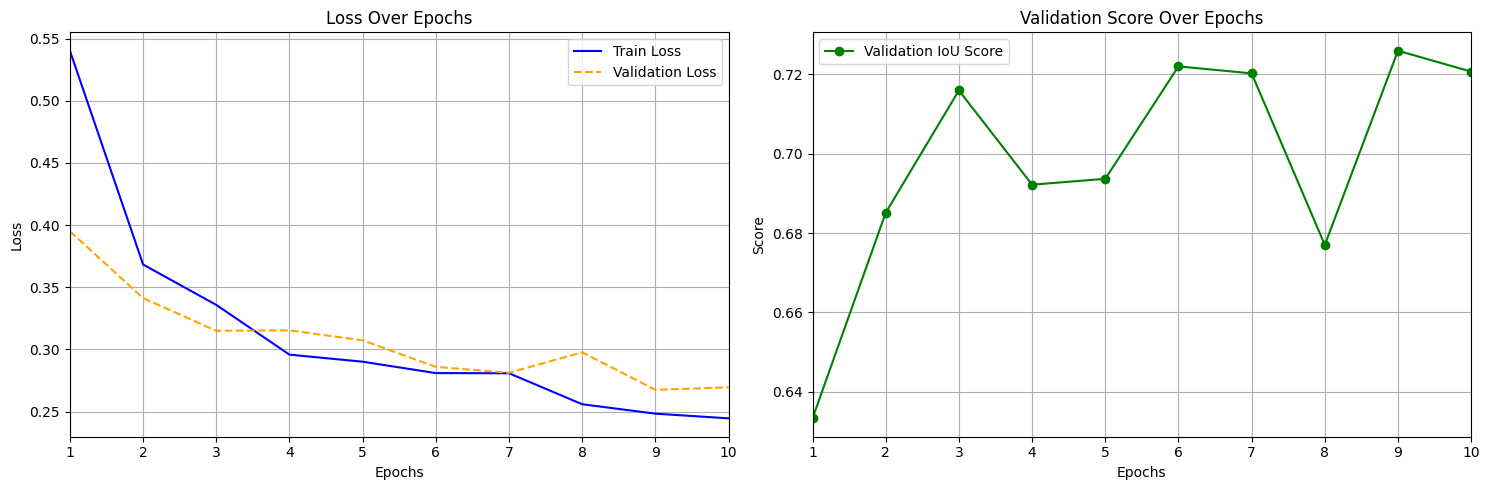

In [ ]:
metrics_unet_bce_train_val, time_unet_bce = train_model(model, optimizer, criterion, num_epochs, train_dataloader, val_dataloader, device, ckpt_path)

Проверим метрику на тесте

In [ ]:
ckpt_name = 'best_model_epoch_9.pt'

In [ ]:
metrics_unet_bce = test(model, test_dataloader, device, ckpt_path, ckpt_name)

<ipython-input-36-a81f976e9b3e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


In [ ]:
iou_unet_bce = metrics_unet_bce['iou']
loss_unet_bce = metrics_unet_bce['loss']

In [ ]:
print(f'BCE Loss модели Unet: {loss_unet_bce}, iou_score: {iou_unet_bce}, время обучения: {time_unet_bce}')

BCE Loss модели Unet: 0.2952533960342407, iou_score: 0.707442045211792, время обучения: 46.960025787353516


**Модель UNet с функцией потерь Dice**

In [ ]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = dice_loss
ckpt_path = '/content/checkpoints_Unet_Dice'
num_epochs = 10

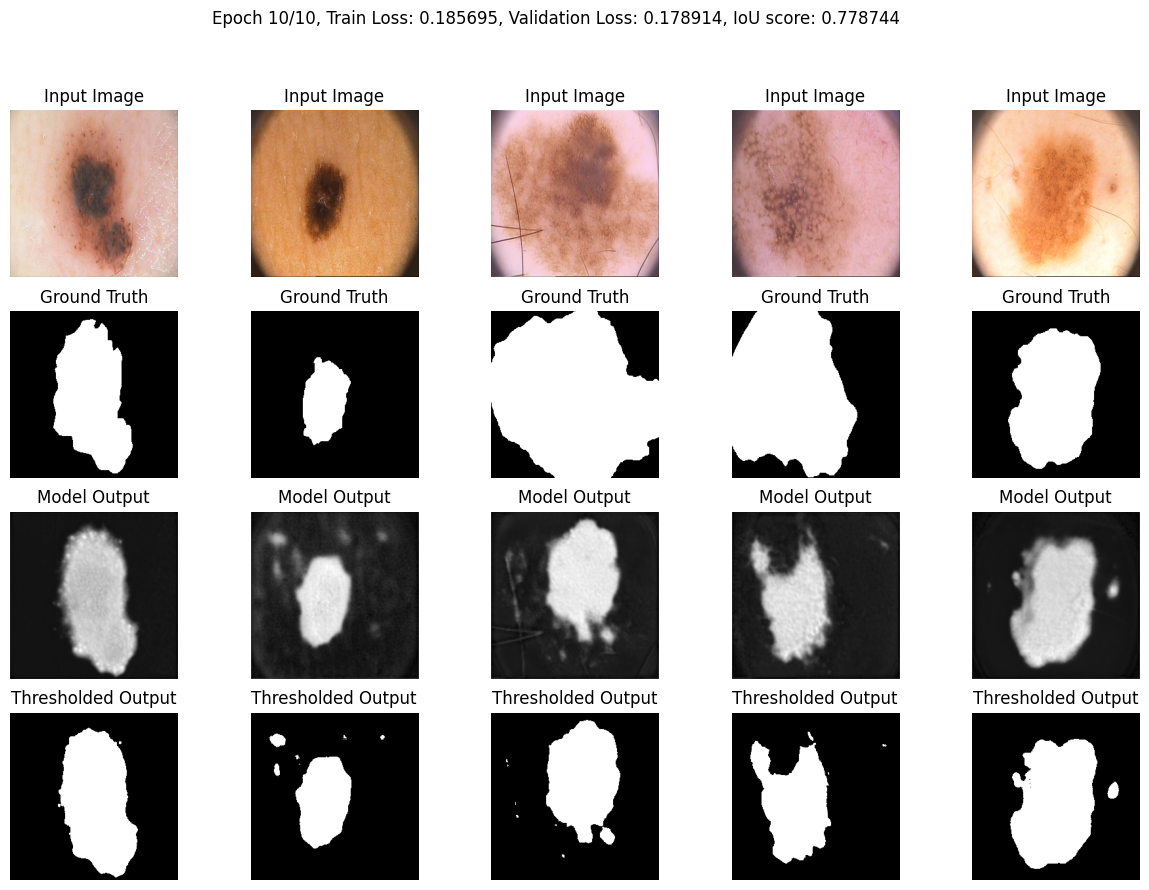

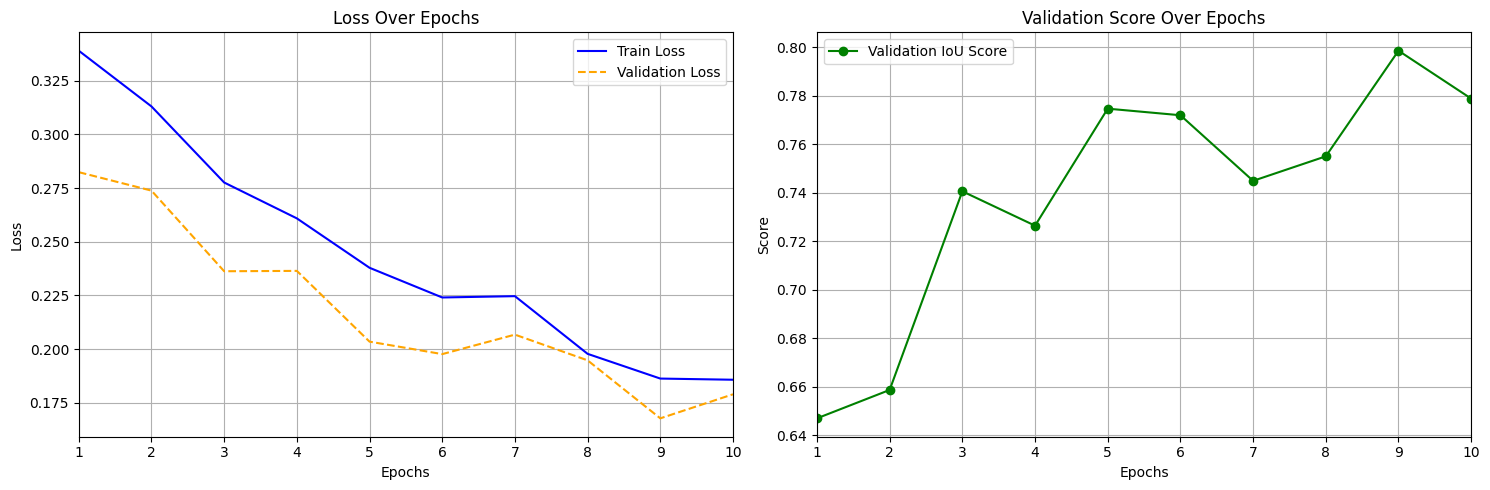

In [ ]:
metrics_unet_dice_train_val, time_unet_dice = train_model(model, optimizer, criterion, num_epochs, train_dataloader, val_dataloader, device, ckpt_path)

In [ ]:
ckpt_name = 'best_model_epoch_8.pt'

In [ ]:
metrics_unet_dice = test(model, test_dataloader, device, ckpt_path, ckpt_name)

<ipython-input-36-a81f976e9b3e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


In [ ]:
iou_unet_dice = metrics_unet_dice['iou']
loss_unet_dice = metrics_unet_dice['loss']

In [ ]:
print(f'Dice Loss модели Unet: {loss_unet_dice}, iou_score: {iou_unet_dice}, время обучения: {time_unet_dice}')

Dice Loss модели Unet: 0.214920312166214, iou_score: 0.7445091009140015, время обучения: 46.8581645488739


**Модель UNet с функцией потерь Focal**

In [ ]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = sigmoid_focal_loss
ckpt_path = '/content/checkpoints_Unet_Focal'
num_epochs = 10

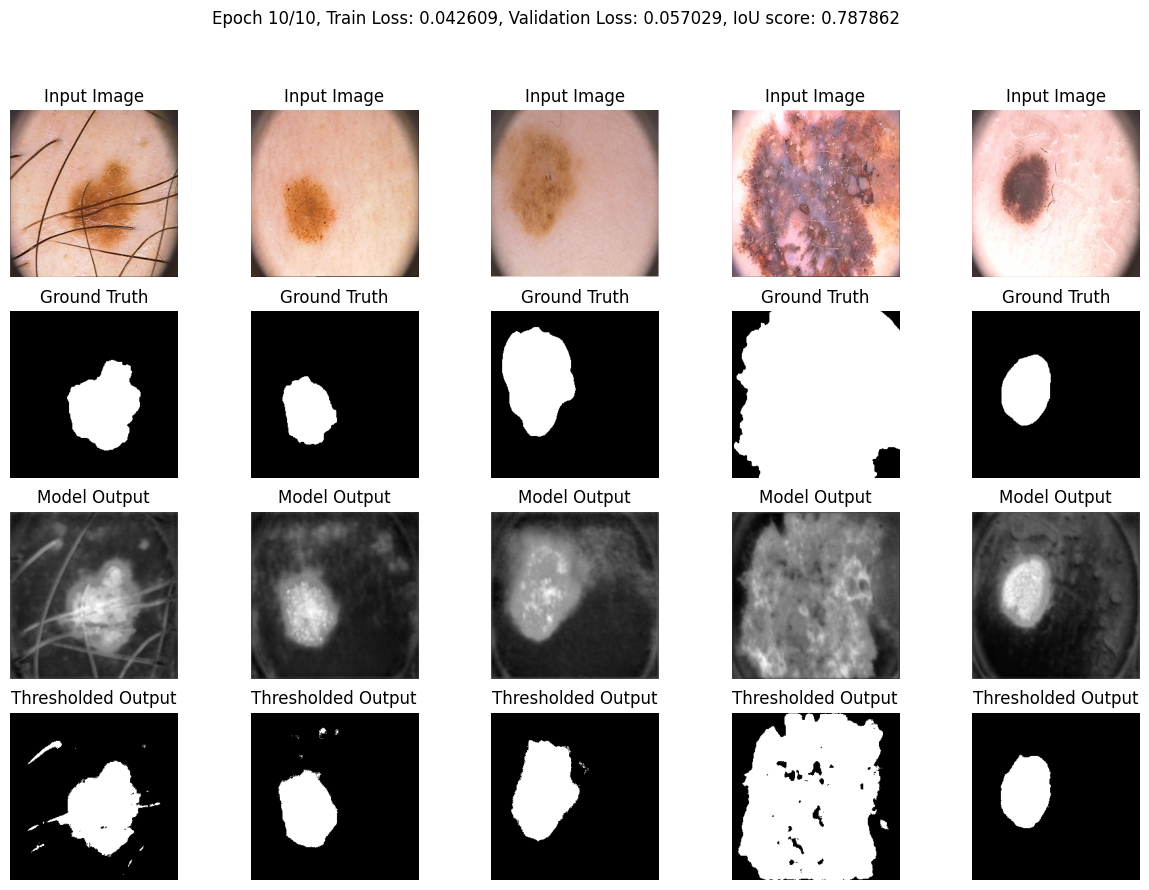

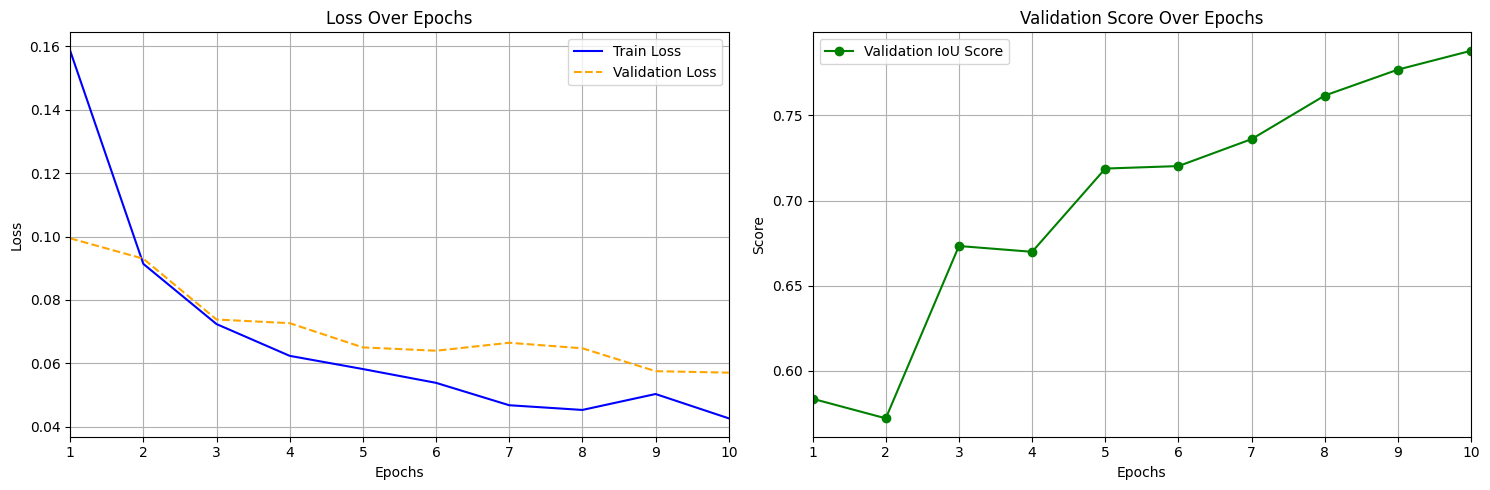

In [ ]:
metrics_unet_focal_train_val, time_unet_focal = train_model_with_focal_loss(model, optimizer, criterion, num_epochs, train_dataloader, val_dataloader, device, ckpt_path)

In [ ]:
ckpt_name = 'best_model_epoch_10.pt'

In [ ]:
metrics_unet_focal = test_model_with_focal_loss(model, criterion, test_dataloader, device, ckpt_path, ckpt_name)

<ipython-input-69-5d1046dce256>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


In [ ]:
iou_unet_focal = metrics_unet_focal['iou']
loss_unet_focal = metrics_unet_focal['loss']

In [ ]:
print(f'Focal Loss модели Unet: {loss_unet_focal}, iou_score: {iou_unet_focal}, время обучения: {time_unet_focal}')

Focal Loss модели Unet: 0.07023291289806366, iou_score: 0.7344197034835815, время обучения: 46.8197181224823


## Вывод результатов

In [ ]:
print(f'BCE Loss модели Segnet: {loss_segnet_bce}, iou_score: {iou_segnet_bce}, время обучения: {time_segnet_bce}')

BCE Loss модели Segnet: 0.26182329654693604, iou_score: 0.7511382699012756, время обучения: 42.1908757686615


In [ ]:
print(f'Dice Loss модели Segnet: {loss_segnet_dice}, iou_score: {iou_segnet_dice}, время обучения: {time_segnet_dice}')

Dice Loss модели Segnet: 0.18104061484336853, iou_score: 0.7153823375701904, время обучения: 43.59042000770569


In [ ]:
print(f'Focal Loss модели Segnet: {loss_segnet_focal}, iou_score: {iou_segnet_focal}, время обучения: {time_segnet_focal}')

Focal Loss модели Segnet: 0.1661064177751541, iou_score: 0.04126550257205963, время обучения: 42.94926118850708


In [ ]:
print(f'BCE Loss модели Unet: {loss_unet_bce}, iou_score: {iou_unet_bce}, время обучения: {time_unet_bce}')

BCE Loss модели Unet: 0.2952533960342407, iou_score: 0.707442045211792, время обучения: 46.960025787353516


In [ ]:
print(f'Dice Loss модели Unet: {loss_unet_dice}, iou_score: {iou_unet_dice}, время обучения: {time_unet_dice}')

Dice Loss модели Unet: 0.214920312166214, iou_score: 0.7445091009140015, время обучения: 46.8581645488739


In [ ]:
print(f'Focal Loss модели Unet: {loss_unet_focal}, iou_score: {iou_unet_focal}, время обучения: {time_unet_focal}')

Focal Loss модели Unet: 0.07023291289806366, iou_score: 0.7344197034835815, время обучения: 46.8197181224823


1.   По метрике IoU наилучшие предсказания даёт модель SegNet с лоссом BCE
2.   Наименьший лосс у модели Unet с Focal Loss
Если проводить сравнение моделей с одинаковым лоссом, то по BCE лучше SegNet, по Dice лучше SegNet, а по Focal Loss лучше Unet.
3. Время на обучение SegNet затрачивается меньше чем UNet при выбранном loss.
4. Визуально результаты работы моделей похожи и хорошо сегментируют объекты.





